In [3]:
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objects as go
import scipy
from matplotlib.lines import Line2D
import networkx as nx
from tqdm import tqdm
import matplotlib.colors as mcolors
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from scipy.optimize import curve_fit
import psycopg2
from matplotlib.patches import Patch
import matplotlib as mpl
mpl.rcParams['mathtext.fontset'] = 'cm'  # Computer Modern for math


axis_label_fontsize = 17
tick_label_fontsize = 12
title_fontsize = 13
legend_fontsize = 9
pd.set_option("display.max_columns",100)

colors = [
    "#2ab421",   # Less vivid green
    "#f93a2e",  # Vivid red
    "#d02670",  # Strong pink
    "#ff7a00",  # Bright orange
    "#1dd3c1",  # Vivid turquoise
    "#8a2be2",   # Electric purple
    "#ffafd2",  # Bright pink
    "#fff537",  # Bright yellow
    "#4589ff",  # Vibrant blue
    "#d4b237",  # Bold yellow-orange
    "#c677e2",  # Lively purple
    "#a2a9b0",  # Muted grayish blue
    "#baf0ce",  # Soft green
    "#b7e1ff",  # Light blue
    "#ebeced",  # Light gray
    "#dbc7ff",  # Pale purple
    "#6fdc8c",  # Bright green
]

In [4]:
df = pd.read_csv("results/energy_consumption_and_trends_firms_2020-2024.csv")
df = df.sort_values(by="parent_nace").reset_index(drop = True)

colors_dict = dict(zip(df.parent_nace.unique(), colors))
colors_dict

df_nace_desc = pd.read_csv("data/nace_description.csv")
nace_desc_dict = dict(zip(df_nace_desc.nace.unique(), df_nace_desc.description.unique()))

df["color"] = df["parent_nace"].map(colors_dict)
df["parent_nace_desc"] = df["parent_nace"].map(nace_desc_dict)
df["parent_nace_desc"] = df["parent_nace"] + " - " + df["parent_nace_desc"].apply(lambda x: x if len(x) <= 30 else x[:27] + "...")
df

,firm_id,oil_purchases_2020_1,gas_purchases_2020_1,electricity_purchases_2020_1,oil_purchases_2020_2,gas_purchases_2020_2,electricity_purchases_2020_2,oil_purchases_2021_1,gas_purchases_2021_1,electricity_purchases_2021_1,oil_purchases_2021_2,gas_purchases_2021_2,electricity_purchases_2021_2,oil_purchases_2022_1,gas_purchases_2022_1,electricity_purchases_2022_1,oil_purchases_2022_2,gas_purchases_2022_2,electricity_purchases_2022_2,oil_purchases_2023_1,gas_purchases_2023_1,electricity_purchases_2023_1,oil_purchases_2023_2,gas_purchases_2023_2,electricity_purchases_2023_2,oil_purchases_2024_1,gas_purchases_2024_1,electricity_purchases_2024_1,oil_purchases_2024_2,gas_purchases_2024_2,electricity_purchases_2024_2,revenue_2020,revenue_2021,revenue_2022,revenue_2023,revenue_2024,employment_2020,employment_2021,employment_2022,employment_2023,employment_2024,ets_flag,nace2,nace4,parent_nace,fossil_purchases_2020,fossil_purchases_2021,fossil_purchases_2022,fossil_purchases_2023,fossil_purchases_2024,...,elec_share_exp_intercept_omit2020_ols,elec_share_exp_growth_omit2021_ols,elec_share_exp_intercept_omit2021_ols,elec_share_exp_growth_omit2022_ols,elec_share_exp_intercept_omit2022_ols,elec_share_exp_growth_omit2023_ols,elec_share_exp_intercept_omit2023_ols,elec_share_exp_growth_omit2024_ols,elec_share_exp_intercept_omit2024_ols,elec_share_exp_growth_robust,elec_share_exp_intercept_robust,elec_share_exp_growth_se_robust,elec_share_exp_growth_omit2020_robust,elec_share_exp_intercept_omit2020_robust,elec_share_exp_growth_omit2021_robust,elec_share_exp_intercept_omit2021_robust,elec_share_exp_growth_omit2022_robust,elec_share_exp_intercept_omit2022_robust,elec_share_exp_growth_omit2023_robust,elec_share_exp_intercept_omit2023_robust,elec_share_exp_growth_omit2024_robust,elec_share_exp_intercept_omit2024_robust,lowcarbon_elec_share_exp_growth_ols,lowcarbon_elec_share_exp_intercept_ols,lowcarbon_elec_share_exp_growth_se_ols,lowcarbon_elec_share_exp_growth_omit2020_ols,lowcarbon_elec_share_exp_intercept_omit2020_ols,lowcarbon_elec_share_exp_growth_omit2021_ols,lowcarbon_elec_share_exp_intercept_omit2021_ols,lowcarbon_elec_share_exp_growth_omit2022_ols,lowcarbon_elec_share_exp_intercept_omit2022_ols,lowcarbon_elec_share_exp_growth_omit2023_ols,lowcarbon_elec_share_exp_intercept_omit2023_ols,lowcarbon_elec_share_exp_growth_omit2024_ols,lowcarbon_elec_share_exp_intercept_omit2024_ols,lowcarbon_elec_share_exp_growth_robust,lowcarbon_elec_share_exp_intercept_robust,lowcarbon_elec_share_exp_growth_se_robust,lowcarbon_elec_share_exp_growth_omit2020_robust,lowcarbon_elec_share_exp_intercept_omit2020_robust,lowcarbon_elec_share_exp_growth_omit2021_robust,lowcarbon_elec_share_exp_intercept_omit2021_robust,lowcarbon_elec_share_exp_growth_omit2022_robust,lowcarbon_elec_share_exp_intercept_omit2022_robust,lowcarbon_elec_share_exp_growth_omit2023_robust,lowcarbon_elec_share_exp_intercept_omit2023_robust,lowcarbon_elec_share_exp_growth_omit2024_robust,lowcarbon_elec_share_exp_intercept_omit2024_robust,color,parent_nace_desc
0,52,6430106,186048,323982,0,7431855,418345,6075592,491807,487870,0,498040,375447,0,495708,399483,0,218554,301837,0,486782,320685,6408612,357246,254905,0,365528,142298,8153627,156411,476892,7275493325,7376454009,7199749652,7453260002,7701065760,44,42,41,43,43,0,1,137,A,14048009,7065439,714262,7252640,8675566,...,-1.772380,0.224911,-1.705511,0.206782,-1.470426,0.273183,-1.632996,-0.114227,-1.311987,0.206782,-1.632996,0.198916,0.379865,-1.772380,0.224911,-1.705511,0.206782,-1.470426,0.280960,-1.578554,-0.088670,-1.286430,0.253737,-2.127357,0.201105,0.433354,-2.232853,0.270759,-2.195443,0.253737,-1.959482,0.318222,-2.127357,-0.068515,-1.805105,0.253737,-2.127357,0.201105,0.433354,-2.232853,0.270759,-2.195443,0.253737,-1.959482,0.325283,-2.077927,-0.031313,-1.767903,#2ab421,"A - AGRICULTURE, FORESTRY AND F..."
1,39,0,274024,7560238,7845935,195151,301651,0,417595,252654,8708257,442460,232821,0,7809996,136471,0,432057,476047,0,141230,408610,0,

In [16]:
# --- Transitioning flag (using low-carbon elec shares) ---
df['transitioning'] = np.where(
    ((df['lowcarbon_elec_share_exp_growth_robust'] > 0) & 
     (df['low-carbon_elec_share_growth_robust'] > 0)),
    "transitioning", "not transitioning"
)
df["transitioning_binary"] = np.where(
    ((df['lowcarbon_elec_share_exp_growth_robust'] > 0) & 
     (df['low-carbon_elec_share_growth_robust'] > 0)),
    1, 0
)

# --- Energy input shares ---
for year in range(2020, 2025):
    fossil_col = f"oil_purchases_{year}_1", f"oil_purchases_{year}_2", f"gas_purchases_{year}_1", f"gas_purchases_{year}_2"
    elec_col = f"electricity_purchases_{year}_1", f"electricity_purchases_{year}_2"

    fossil_sum = df[list(fossil_col)].sum(axis=1)
    elec_sum = df[list(elec_col)].sum(axis=1)

    df[f"fossil_input_{year}"] = fossil_sum
    df[f"elec_input_{year}"] = elec_sum

    rev_col = f"revenue_{year}" if f"revenue_{year}" in df.columns else "revenue_2023"  # fallback for 2024

    df[f"energy_input_share_{year}"] = (fossil_sum + elec_sum) / df[rev_col]
    df[f"fossil_input_share_{year}"] = fossil_sum / df[rev_col]
    df[f"elec_input_share_{year}"] = elec_sum / df[rev_col]

# --- Averages ---
df["avg_employment"] = df[[f"employment_{y}" for y in range(2020, 2025)]].mean(axis=1)
df["avg_energy_input_share"] = df[[f"energy_input_share_{y}" for y in range(2020, 2025)]].mean(axis=1)
df["avg_fossil_input_share"] = df[[f"fossil_input_share_{y}" for y in range(2020, 2025)]].mean(axis=1)
df["avg_elec_input_share"] = df[[f"elec_input_share_{y}" for y in range(2020, 2025)]].mean(axis=1)

df["avg_revenue"] = df[[f"revenue_{y}" for y in range(2020, 2025) if f"revenue_{y}" in df.columns]].mean(axis=1)
df["avg_revenue_per_energy"] = df["avg_revenue"] / df["avg_total_consumption_KWH"]

# Costs (proxy = purchases)
elec_cols = [c for c in df.columns if c.startswith("electricity_purchases_")]
fossil_cols = [c for c in df.columns if c.startswith("oil_purchases_") or c.startswith("gas_purchases_")]
df["avg_elec_cost"] = df[elec_cols].mean(axis=1)
df["avg_fossil_cost"] = df[fossil_cols].mean(axis=1)

# # Consumption
# df["avg_elec_consumption_KWH"] = df[[f"elec_consumption_KWH_{y}" for y in range(2020, 2025)]].mean(axis=1)
# df["avg_fossil_consumption_KWH"] = df[[f"fossil_consumption_KWH_{y}" for y in range(2020, 2025)]].mean(axis=1)

df.parent_nace.unique()


array(['A', 'B', 'C'], dtype=object)

In [17]:
# --- Log transforms (safe logs: only positive values) ---
log_vars = {
    "log_revenue_2023": "revenue_2023",
    "log_avg_employment": "avg_employment",
    "log_avg_revenue": "avg_revenue",
    "log_avg_total_consumption_KWH": "avg_total_consumption_KWH",
    "log_avg_elec_consumption_KWH": "avg_elec_consumption_KWH",
    "log_avg_fossil_consumption_KWH": "avg_fossil_consumption_KWH",
    "log_avg_revenue_per_energy": "avg_revenue_per_energy",
    "log_avg_elec_cost": "avg_elec_cost",
    "log_avg_fossil_cost": "avg_fossil_cost",
    "log_avg_energy_input_share": "avg_energy_input_share",
    "log_avg_fossil_input_share": "avg_fossil_input_share",
    "log_avg_elec_input_share": "avg_elec_input_share"
}

for log_col, base_col in log_vars.items():
    df[log_col] = df[base_col].apply(
        lambda x: np.log(x) if pd.notnull(x) and x > 0 else np.nan
    )

# --- Predictors ---
predictors = [
    "log_avg_fossil_input_share",
    "log_avg_elec_input_share",
    "log_avg_revenue",
    "log_avg_employment",
    "log_avg_total_consumption_KWH",
]

results = {}

# --- Logistic regression by sector (parent_nace) ---
for parent_nace in df['parent_nace'].dropna().unique():
    print(parent_nace)
    df_sector = df[df['parent_nace'] == parent_nace].copy()
    df_sector = df_sector[predictors + ['transitioning_binary']].dropna()
    
    if df_sector.empty:
        continue
    
    X = sm.add_constant(df_sector[predictors])
    y = df_sector['transitioning_binary']
    
    try:
        model = sm.Logit(y, X)
        result = model.fit(disp=False)
        
        coefs = {}
        for var in result.params.index:
            if var == "const":   # skip intercept
                continue

            coefs[var] = {
                "coef": result.params[var],
                "std_err": result.bse[var],
                "p_value": result.pvalues[var],
                "formatted": f"{result.params[var]:.3f} ({result.bse[var]:.3f})"
            }

        results[parent_nace] = coefs
    
    except Exception as e:
        print(f"Sector {parent_nace}: regression failed ({e})")

# --- Convert to long format ---
results_long = []
for sector, coefs in results.items():
    for predictor, vals in coefs.items():
        results_long.append({
            "sector": sector,
            "predictor": predictor,
            "coef": vals["coef"],
            "std_err": vals["std_err"],
            "p_value": vals["p_value"]
        })

results_long = pd.DataFrame(results_long)

# --- Compute odds ratios for 1% increase ---
results_long['odds_ratio_1pct'] = np.exp(results_long['coef'] * 0.1)
results_long['ci_lower'] = np.exp((results_long['coef'] - 1.96*results_long['std_err']) * 0.1)
results_long['ci_upper'] = np.exp((results_long['coef'] + 1.96*results_long['std_err']) * 0.1)

# Preview
print(results_long.head(10)[["sector", "predictor", "coef", "std_err", "odds_ratio_1pct", "ci_lower", "ci_upper"]])


A
Sector A: regression failed (Singular matrix)
B
C
  sector                      predictor      coef   std_err  odds_ratio_1pct  \
0      B     log_avg_fossil_input_share -3.990818  1.942363         0.670936   
1      B       log_avg_elec_input_share -0.249033  0.918907         0.975404   
2      B                log_avg_revenue -2.798187  2.414092         0.755921   
3      B             log_avg_employment  0.252495  0.641178         1.025571   
4      B  log_avg_total_consumption_KWH  1.444879  1.096293         1.155448   
5      C     log_avg_fossil_input_share  1.932257  1.719101         1.213157   
6      C       log_avg_elec_input_share  3.083161  1.308114         1.361131   
7      C                log_avg_revenue  5.313808  2.641187         1.701280   
8      C             log_avg_employment  1.244066  0.673664         1.132476   
9      C  log_avg_total_consumption_KWH  0.076011  1.046028         1.007630   

   ci_lower  ci_upper  
0  0.458505  0.981789  
1  0.814640  1.1678

c:\Users\Johannes\.conda\envs\ml2\Lib\site-packages\statsmodels\discrete\discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
c:\Users\Johannes\.conda\envs\ml2\Lib\site-packages\statsmodels\discrete\discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


<>:23: SyntaxWarning: invalid escape sequence '\o'
<>:24: SyntaxWarning: invalid escape sequence '\o'
<>:25: SyntaxWarning: invalid escape sequence '\o'
<>:26: SyntaxWarning: invalid escape sequence '\o'
<>:27: SyntaxWarning: invalid escape sequence '\o'
<>:28: SyntaxWarning: invalid escape sequence '\o'
<>:29: SyntaxWarning: invalid escape sequence '\o'
<>:23: SyntaxWarning: invalid escape sequence '\o'
<>:24: SyntaxWarning: invalid escape sequence '\o'
<>:25: SyntaxWarning: invalid escape sequence '\o'
<>:26: SyntaxWarning: invalid escape sequence '\o'
<>:27: SyntaxWarning: invalid escape sequence '\o'
<>:28: SyntaxWarning: invalid escape sequence '\o'
<>:29: SyntaxWarning: invalid escape sequence '\o'
C:\Users\Johannes\AppData\Local\Temp\ipykernel_16196\2973677889.py:23: SyntaxWarning: invalid escape sequence '\o'
  "log_avg_energy_input_share": "total energy\ncosts share $\overline{tc}_i$",
C:\Users\Johannes\AppData\Local\Temp\ipykernel_16196\2973677889.py:24: SyntaxWarning: invali

['B', 'C']


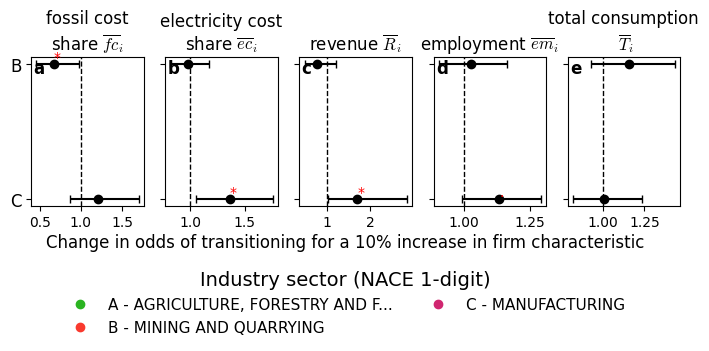

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as mticker
import string

axis_label_fontsize = 12
legend_fontsize = 11
ticks_fontsize = 10
title_fontsize = 12

# Clean legend dictionary (avoid mining/finance drop for toy dataset)
colors_dict_with_desc = dict(zip(df["parent_nace_desc"], df["color"]))

def get_significance(p):
    if p < 0.001: return '***'
    elif p < 0.01: return '**'
    elif p < 0.05: return '*'
    elif p < 0.1: return '.'
    else: return ''

# Predictor labels (with line breaks)
predictor_labels = {
    "log_avg_energy_input_share": "total energy\ncosts share $\overline{tc}_i$",
    "log_avg_fossil_input_share": "fossil cost\nshare $\overline{fc}_i$",
    "log_avg_elec_input_share": "electricity cost\nshare $\overline{ec}_i$",
    "log_avg_revenue": "revenue $\overline{R}_i$",
    "log_avg_employment": "employment $\overline{em}_i$",
    "log_avg_total_consumption_KWH": "total consumption\n $\overline{T}_i$",
    "log_avg_revenue_per_energy": "revenue per\ntotal consumption $\overline{RT}_i$"
}

def plot_forest_odds_ratio(results_long, predictors, figsize=(7, 0.5)):
    n_preds = len(predictors)
    fig, axes = plt.subplots(
        1, n_preds, figsize=(figsize[0], figsize[1]*n_preds), sharey=True
    )

    if n_preds == 1:
        axes = [axes]

    # Consistent sector ordering
    sectors = sorted(results_long["sector"].unique())
    print(sectors)

    for i, (ax, predictor) in enumerate(zip(axes, predictors)):
        df_plot = results_long[results_long["predictor"] == predictor]
        df_plot = df_plot.set_index("sector").reindex(sectors).reset_index()
        
        odds_ratio = np.exp(df_plot['coef'] * 0.1)
        ci_lower = np.exp(df_plot['coef'] * 0.1 - 1.96 * df_plot['std_err'] * 0.1)
        ci_upper = np.exp(df_plot['coef'] * 0.1 + 1.96 * df_plot['std_err'] * 0.1)

        y_pos = np.arange(len(sectors))
        labels = df_plot["sector"].values
        pvals = df_plot['p_value'].values

        # Plot odds ratio with CI
        ax.errorbar(
            odds_ratio,
            y_pos,
            xerr=[odds_ratio - ci_lower, ci_upper - odds_ratio],
            fmt='o', color='black', capsize=3
        )

        # Add significance stars
        for x, y, p in zip(odds_ratio, y_pos, pvals):
            if not np.isnan(x):
                ax.text(x+0.002, y-0.05, get_significance(p),
                        va='center', ha='left', fontsize=10, color='red')

        ax.axvline(1, color='black', linestyle='--', linewidth=1)  # OR=1 ref line
        ax.set_title(predictor_labels.get(predictor, predictor), fontsize=title_fontsize)
        ax.set_yticks(y_pos)
        ax.set_yticklabels(labels, fontsize=axis_label_fontsize)
        ax.invert_yaxis()

        # Custom x-limits per predictor
        # if predictor in ["log_avg_energy_input_share", "log_avg_fossil_input_share", "log_avg_employment"]:
        #     ax.set_xlim(0.8, 1.2)
        #     ax.set_xticks([0.8, 1, 1.2])
        # elif predictor in ["log_avg_elec_input_share", "log_avg_total_consumption_KWH"]:
        #     ax.set_xlim(0.7, 1.3)
        #     ax.set_xticks([0.8, 1, 1.2])
        # else:
        #     ax.set_xlim(0.8, 1.2)

        # Subplot label (a, b, c…)
        ax.text(0.02, 0.99, f"{string.ascii_lowercase[i]}",
                transform=ax.transAxes, fontsize=title_fontsize,
                va='top', ha='left', weight='bold')

    # --- Legend ---
    handles = [plt.Line2D([0], [0], marker='o', color=color, linestyle="",
                          label=desc) for desc, color in colors_dict_with_desc.items()]
    
    fig.legend(
        handles, list(colors_dict_with_desc.keys()),
        title="Industry sector (NACE 1-digit)",
        title_fontsize=14,
        loc="upper center", bbox_to_anchor=(0.5, -0.05),
        fontsize=legend_fontsize, ncol=2, frameon=False
    )

    fig.tight_layout()
    fig.text(0.5, -0.01,
             "Change in odds of transitioning for a 10% increase in firm characteristic",
             ha='center', fontsize=axis_label_fontsize)

    plt.savefig("plots/FIG3_combined.pdf", bbox_inches='tight', dpi=300)
    plt.show()

# Example usage:
predictors = results_long['predictor'].unique()
plot_forest_odds_ratio(results_long, predictors)
